<a href="https://colab.research.google.com/github/EmiTR/Testprojekt-ET/blob/main/ET_Pytorch_Wasserstein_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will implement Deep Convolutional Generative Adversarial Nets (GAN) from [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) written by Alec Radford & Luke Metz. 

The dataset I use for this notebook and for other GAN-notebooks is MNIST (Modified National Institute of Standards and Technology) of handwritten digits in black and white.

To use GPU for this notebook in Colab: Runtime -> Change Runtime Type -> GPU. 

# Setup

In [1]:
#Packages for GAN
import torchvision.transforms as transforms 
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch
import torchvision
# Supporting packages
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from time import time
import numpy as np

In [2]:
DIM = 10
NUM_EPOCHS = 20
BATCH_SIZE = DIM*DIM
LEARNING_RATE = 0.00005
#N_CPU = 1
LATENT_DIM = 100
IMG_SIZE = 28
IM_CHANNELS = 1
NUM_CRITIC = 5
WEIGHT_CLIP = 0.01
#sample_interval = 400  

img_shape = (IM_CHANNELS, IMG_SIZE, IMG_SIZE) #1, 28,28

In [3]:
#checking device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Getting data

In [4]:
transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)), #change values if not MNIST
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8)) #should be used to get better output
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(LATENT_DIM, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

# Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(IMG_SIZE** 2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

# Training

In [12]:
# Initialize generator and discriminator
generator = Generator().to(device)
generator.train()

discriminator = Discriminator().to(device)
discriminator.train()

generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)

Tensor = torch.cuda.FloatTensor if device == "cuda" else torch.FloatTensor

<class 'torch.cuda.FloatTensor'>


In [13]:
batches_done = 0
saved_imgs = []
for epoch in range(NUM_EPOCHS):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = Variable(imgs.type(Tensor))
        # train Discriminator
        discriminator_optimizer.zero_grad()
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], LATENT_DIM))))
        # generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        discriminator_loss = torch.mean(discriminator(fake_imgs)) - torch.mean(discriminator(real_imgs)) 
        discriminator_loss.backward()
        discriminator_optimizer.step()
        # clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
        # train the generator every NUM_CRITIC iterations
        if i % NUM_CRITIC == 0:
            # train Generator
            generator_optimizer.zero_grad()
            # generate a batch of fake images
            critics_fake_imgs = generator(z)
            # Adversarial loss
            generator_loss = -torch.mean(discriminator(critics_fake_imgs))
            generator_loss.backward()
            generator_optimizer.step()
        batches_done += 1
    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)
    grid = torchvision.utils.make_grid(critics_fake_imgs.data.cpu(), nrow=DIM)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    saved_imgs.append(img)


Epoch 0 training... done, took 17.5 seconds.
Epoch 1 training... done, took 18.0 seconds.
Epoch 2 training... done, took 16.7 seconds.
Epoch 3 training... done, took 17.0 seconds.
Epoch 4 training... done, took 17.2 seconds.
Epoch 5 training... done, took 16.8 seconds.
Epoch 6 training... done, took 16.7 seconds.
Epoch 7 training... done, took 17.2 seconds.
Epoch 8 training... done, took 17.1 seconds.
Epoch 9 training... done, took 16.9 seconds.
Epoch 10 training... done, took 17.2 seconds.
Epoch 11 training... done, took 16.9 seconds.
Epoch 12 training... done, took 16.8 seconds.
Epoch 13 training... done, took 16.8 seconds.
Epoch 14 training... done, took 16.9 seconds.
Epoch 15 training... done, took 16.7 seconds.
Epoch 16 training... done, took 16.7 seconds.
Epoch 17 training... done, took 17.0 seconds.
Epoch 18 training... done, took 16.8 seconds.
Epoch 19 training... done, took 16.8 seconds.


# Visualization

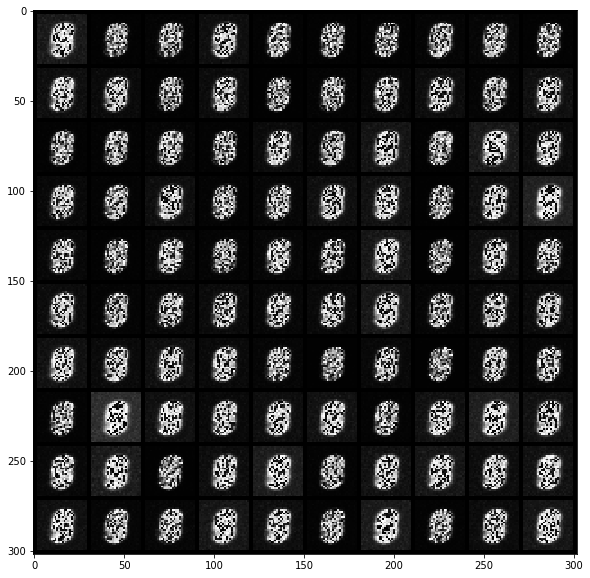

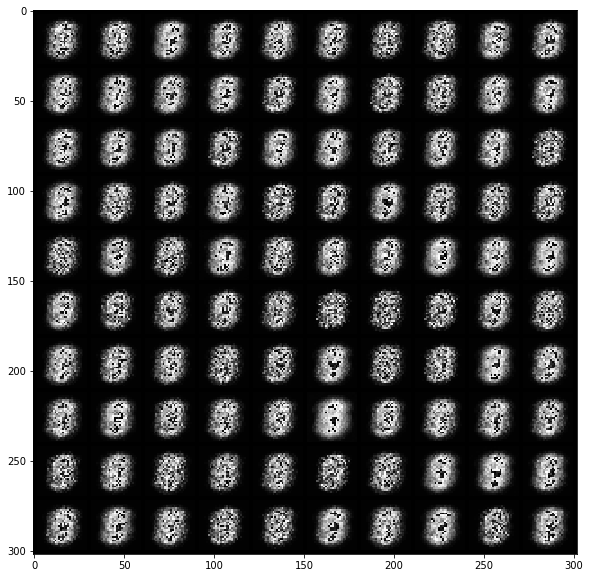

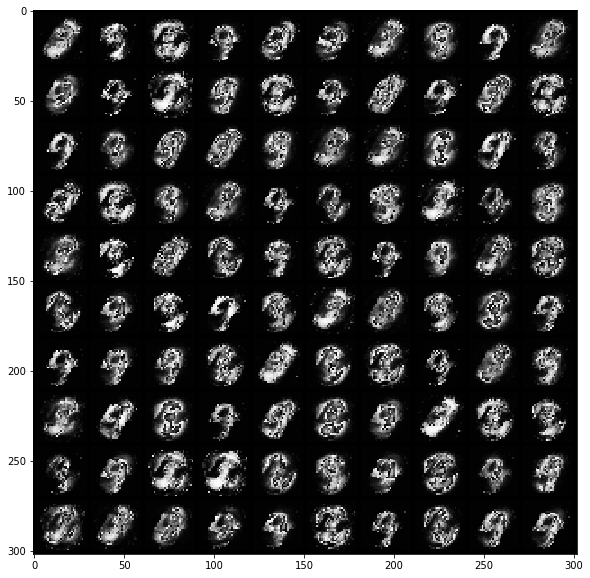

In [17]:
img_indexes = [0, 4, 9] #, 49, 99, 149, 199 if train with NUM_EPOCHS = 200
for i in img_indexes:
    plt.figure(figsize = (DIM, DIM))
    plt.imshow(saved_imgs[i], interpolation='nearest')

# Summary